#  EagleEye tutorial


We import necessary libraries and set up custom plot configurations for consistency.

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Directory setup for custom modules
import sys
module_path = '../../eagleeye'
sys.path.append(module_path)
import EagleEye
from utils_EE import compute_the_null, partitioning_function

# Custom plotting settings
sns.set(style="darkgrid")
plt.rcParams.update({
    'axes.titlesize': 21,
    'axes.labelsize': 17,
    'xtick.labelsize': 17,
    'ytick.labelsize': 17,
    'legend.fontsize': 17,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--',
    'grid.color': 'silver'
})


## 1. Generate the datasets 

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Function to generate uniformly sampled 3D dataset
def generate_uniform_dataset(num_points):
    return np.random.uniform(-1, 1, size=(num_points, 3))

# Function to substitute points within a ball with new uniform samples
def substitute_within_ball(dataset, ball_center, ball_radius, substitution_prob=0.9):
    new_dataset = dataset.copy()
    for i, point in enumerate(dataset):
        if np.random.rand() < substitution_prob:
            if np.linalg.norm(point - ball_center) <= ball_radius:
                # Replace point with a new random uniform sample
                new_dataset[i] = np.random.uniform(-1, 1, size=3)
    return new_dataset

# Number of points
num_points = 50000

# Generate original uniform dataset
original_dataset = generate_uniform_dataset(num_points)

# Define ball center and radius
ball_center = np.array([0.0, 0.0, 0.0])
ball_radius = 0.2

# Generate dataset with points replaced within the ball
Y = substitute_within_ball(original_dataset, ball_center, ball_radius)

X = generate_uniform_dataset(num_points)

In [3]:
#np.save('reference_data.npy',reference_data)
#np.save('test_data.npy',test_data)

### 1.1 Visualize the generated datasets 

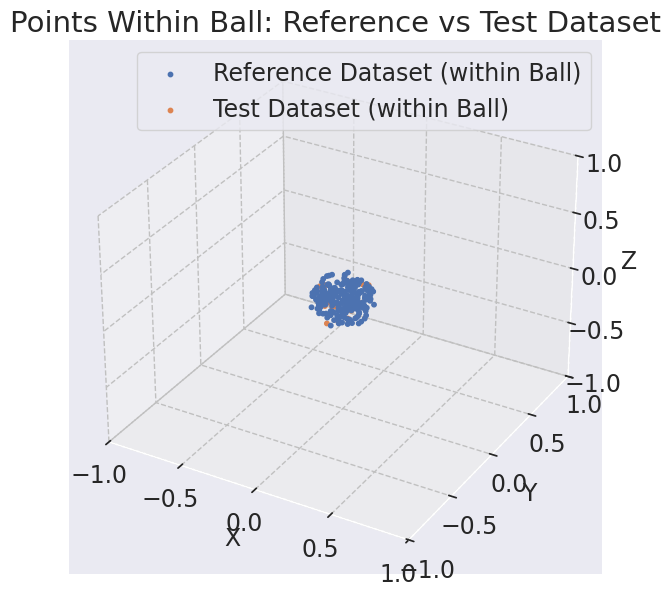

In [4]:
import matplotlib.pyplot as plt
# Function to identify points within the ball
def points_within_ball(dataset, ball_center, ball_radius):
    distances = np.linalg.norm(dataset - ball_center, axis=1)
    return dataset[distances <= ball_radius]

# Get points within the ball for both datasets
points_reference_ball = points_within_ball(X, ball_center, ball_radius)
points_test_ball = points_within_ball(Y, ball_center, ball_radius)

# Plotting the points within the ball for both datasets
fig = plt.figure(figsize=(12, 6))

# Create a 3D axis for plotting
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for points within the ball in reference dataset
ax.scatter(points_reference_ball[:, 0], points_reference_ball[:, 1], points_reference_ball[:, 2], s=10, alpha=1, label="Reference Dataset (within Ball)")

# Scatter plot for points within the ball in test dataset
ax.scatter(points_test_ball[:, 0], points_test_ball[:, 1], points_test_ball[:, 2], s=10, alpha=1, label="Test Dataset (within Ball)")

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("Points Within Ball: Reference vs Test Dataset")

# Display legend
ax.legend()

# Display the plot
plt.tight_layout()
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
plt.show()


In [5]:
points_reference_ball.shape

(228, 3)

## 2. EagleEye

### 2.1 Flagging of putative anomalous points 

### 2.2 Pruning via iterative density equalization (IDE)

Reference dataset: $\mathbf{X}$

Test dataset:      $\mathbf{Y}$ 



In [6]:
#%% EagleEye hyperparameters

p       = len(Y)/(len(Y)+len(X))

K_M     = 500

p_ext   = 1e-5

n_jobs  = 10

In [7]:
stats_null                     = compute_the_null(p=p, K_M=K_M)

In [8]:
#%% Eagle Soar!
# import time
# t = time.time()
result_dict, stats_null = EagleEye.Soar(X, Y, K_M=K_M, p_ext=p_ext, n_jobs=n_jobs, stats_null=stats_null, result_dict_in={})
# elapsed17alt = time.time() - t
# print(f'Elapsed time: {elapsed17alt} seconds')


-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
KNN completed: 10.00 %
KNN completed: 20.00 %
KNN completed: 30.00 %
KNN completed: 40.00 %
KNN completed: 50.00 %
KNN completed: 60.00 %
KNN completed: 70.00 %
KNN completed: 80.00 %
KNN completed: 90.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

### 2.3 Repˆechage 

In [9]:
#%% Cluter the Putative anomalies

clusters = partitioning_function(X,Y,result_dict,p_ext=p_ext,Z=2.65 )

#%% Repêchage

EE_book = EagleEye.Repechage(X,Y,result_dict,clusters,p_ext=1e-5)

-----------------------------------------------------------------
Clustering


/home/johan/anaconda3/envs/EE_v17/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


'!!! No Y-Overdensities found !!!'

<IPython.core.display.Math object>

alpha = 1


'DONE!'

#### Structure of the dictionary containing the results
    EE_book = {
    "Y_OVER_clusters": {
        i: {"Putative": None, "Pruned": None, "Repechaged": None, "Background": None}
        for i in range(len(clusters_plus))
    },
    "X_OVER_clusters": {
        i: {"Putative": None, "Pruned": None, "Repechaged": None, "Background": None}
        for i in range(len(clusters_minus))
    }
    }   

### 2.4 Get Upsilon_i of the equalized sets

In [10]:
# Create a set of banned indices from all clusters
banned_Y = {
    pruned_index
    for cluster in EE_book['Y_OVER_clusters'].values()
    if cluster['Pruned'] is not None  # Check if there's a pruned list
    for pruned_index in cluster['Pruned']
}

# Now create equalized_Y by including indices that are not banned
equalized_Y = [x for x in range(Y.shape[0]) if x not in banned_Y]

equalized_neighbors = result_dict['Knn_model'].kneighbors(Y[equalized_Y, :])[1]

nx = X.shape[0]
mask = ~np.isin(equalized_neighbors, [x + nx for x in banned_Y])

filtered_equalized_neighbors = np.empty((equalized_neighbors.shape[0], K_M), dtype=int)
for i in range(equalized_neighbors.shape[0]):
    # Apply the mask for the current row to filter out banned entries
    valid_neighbors = equalized_neighbors[i, :][mask[i, :]]
    # Optionally, handle cases where there are fewer than K_M valid neighbors
    if valid_neighbors.size < K_M:
        raise ValueError(f"Row {i} does not have enough valid neighbors.")
    # Take the first K_M valid neighbors for the current row
    filtered_equalized_neighbors[i, :] = valid_neighbors[:K_M]

binary_seq                     = (filtered_equalized_neighbors > nx).astype(int)
from EagleEye import PValueCalculator
KSTAR_RANGE = range(20,K_M)
p_val_info_eq                  = PValueCalculator(binary_seq, KSTAR_RANGE, p=p)
Upsilon_i_equalized_Y = p_val_info_eq.min_pval_plus

In [11]:
Upsilon_i_equalized_Y.max()

13.084681503079503

In [12]:
# Create a set of banned indices from all clusters
banned_X = {
    pruned_index
    for cluster in EE_book['X_OVER_clusters'].values()
    if cluster['Pruned'] is not None  # Check if there's a pruned list
    for pruned_index in cluster['Pruned']
}

# Now create equalized_Y by including indices that are not banned
equalized_X = [x for x in range(X.shape[0]) if x not in banned_X]

equalized_neighbors = result_dict['Knn_model'].kneighbors(X[equalized_X, :])[1]

nx = X.shape[0]
mask = ~np.isin(equalized_neighbors, [x for x in banned_X])

filtered_equalized_neighbors = np.empty((equalized_neighbors.shape[0], K_M), dtype=int)
for i in range(equalized_neighbors.shape[0]):
    # Apply the mask for the current row to filter out banned entries
    valid_neighbors = equalized_neighbors[i, :][mask[i, :]]
    # Optionally, handle cases where there are fewer than K_M valid neighbors
    if valid_neighbors.size < K_M:
        raise ValueError(f"Row {i} does not have enough valid neighbors.")
    # Take the first K_M valid neighbors for the current row
    filtered_equalized_neighbors[i, :] = valid_neighbors[:K_M]

binary_seq                     = (~(filtered_equalized_neighbors > nx)).astype(int)
from EagleEye import PValueCalculator
KSTAR_RANGE = range(20,K_M)
p_val_info_eq                  = PValueCalculator(binary_seq, KSTAR_RANGE, p=p)
Upsilon_i_equalized_X = p_val_info_eq.min_pval_plus

In [13]:
Upsilon_i_equalized_X.max()

13.212329292116703

## 3 Results visualization

In [14]:
from visualization_utils_EE import plot_37_article_vanishing

/home/johan/Desktop/EagleEye/examples/Tresette_v7/visualization_utils_EE.py:630: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax0.legend(markerscale=2)


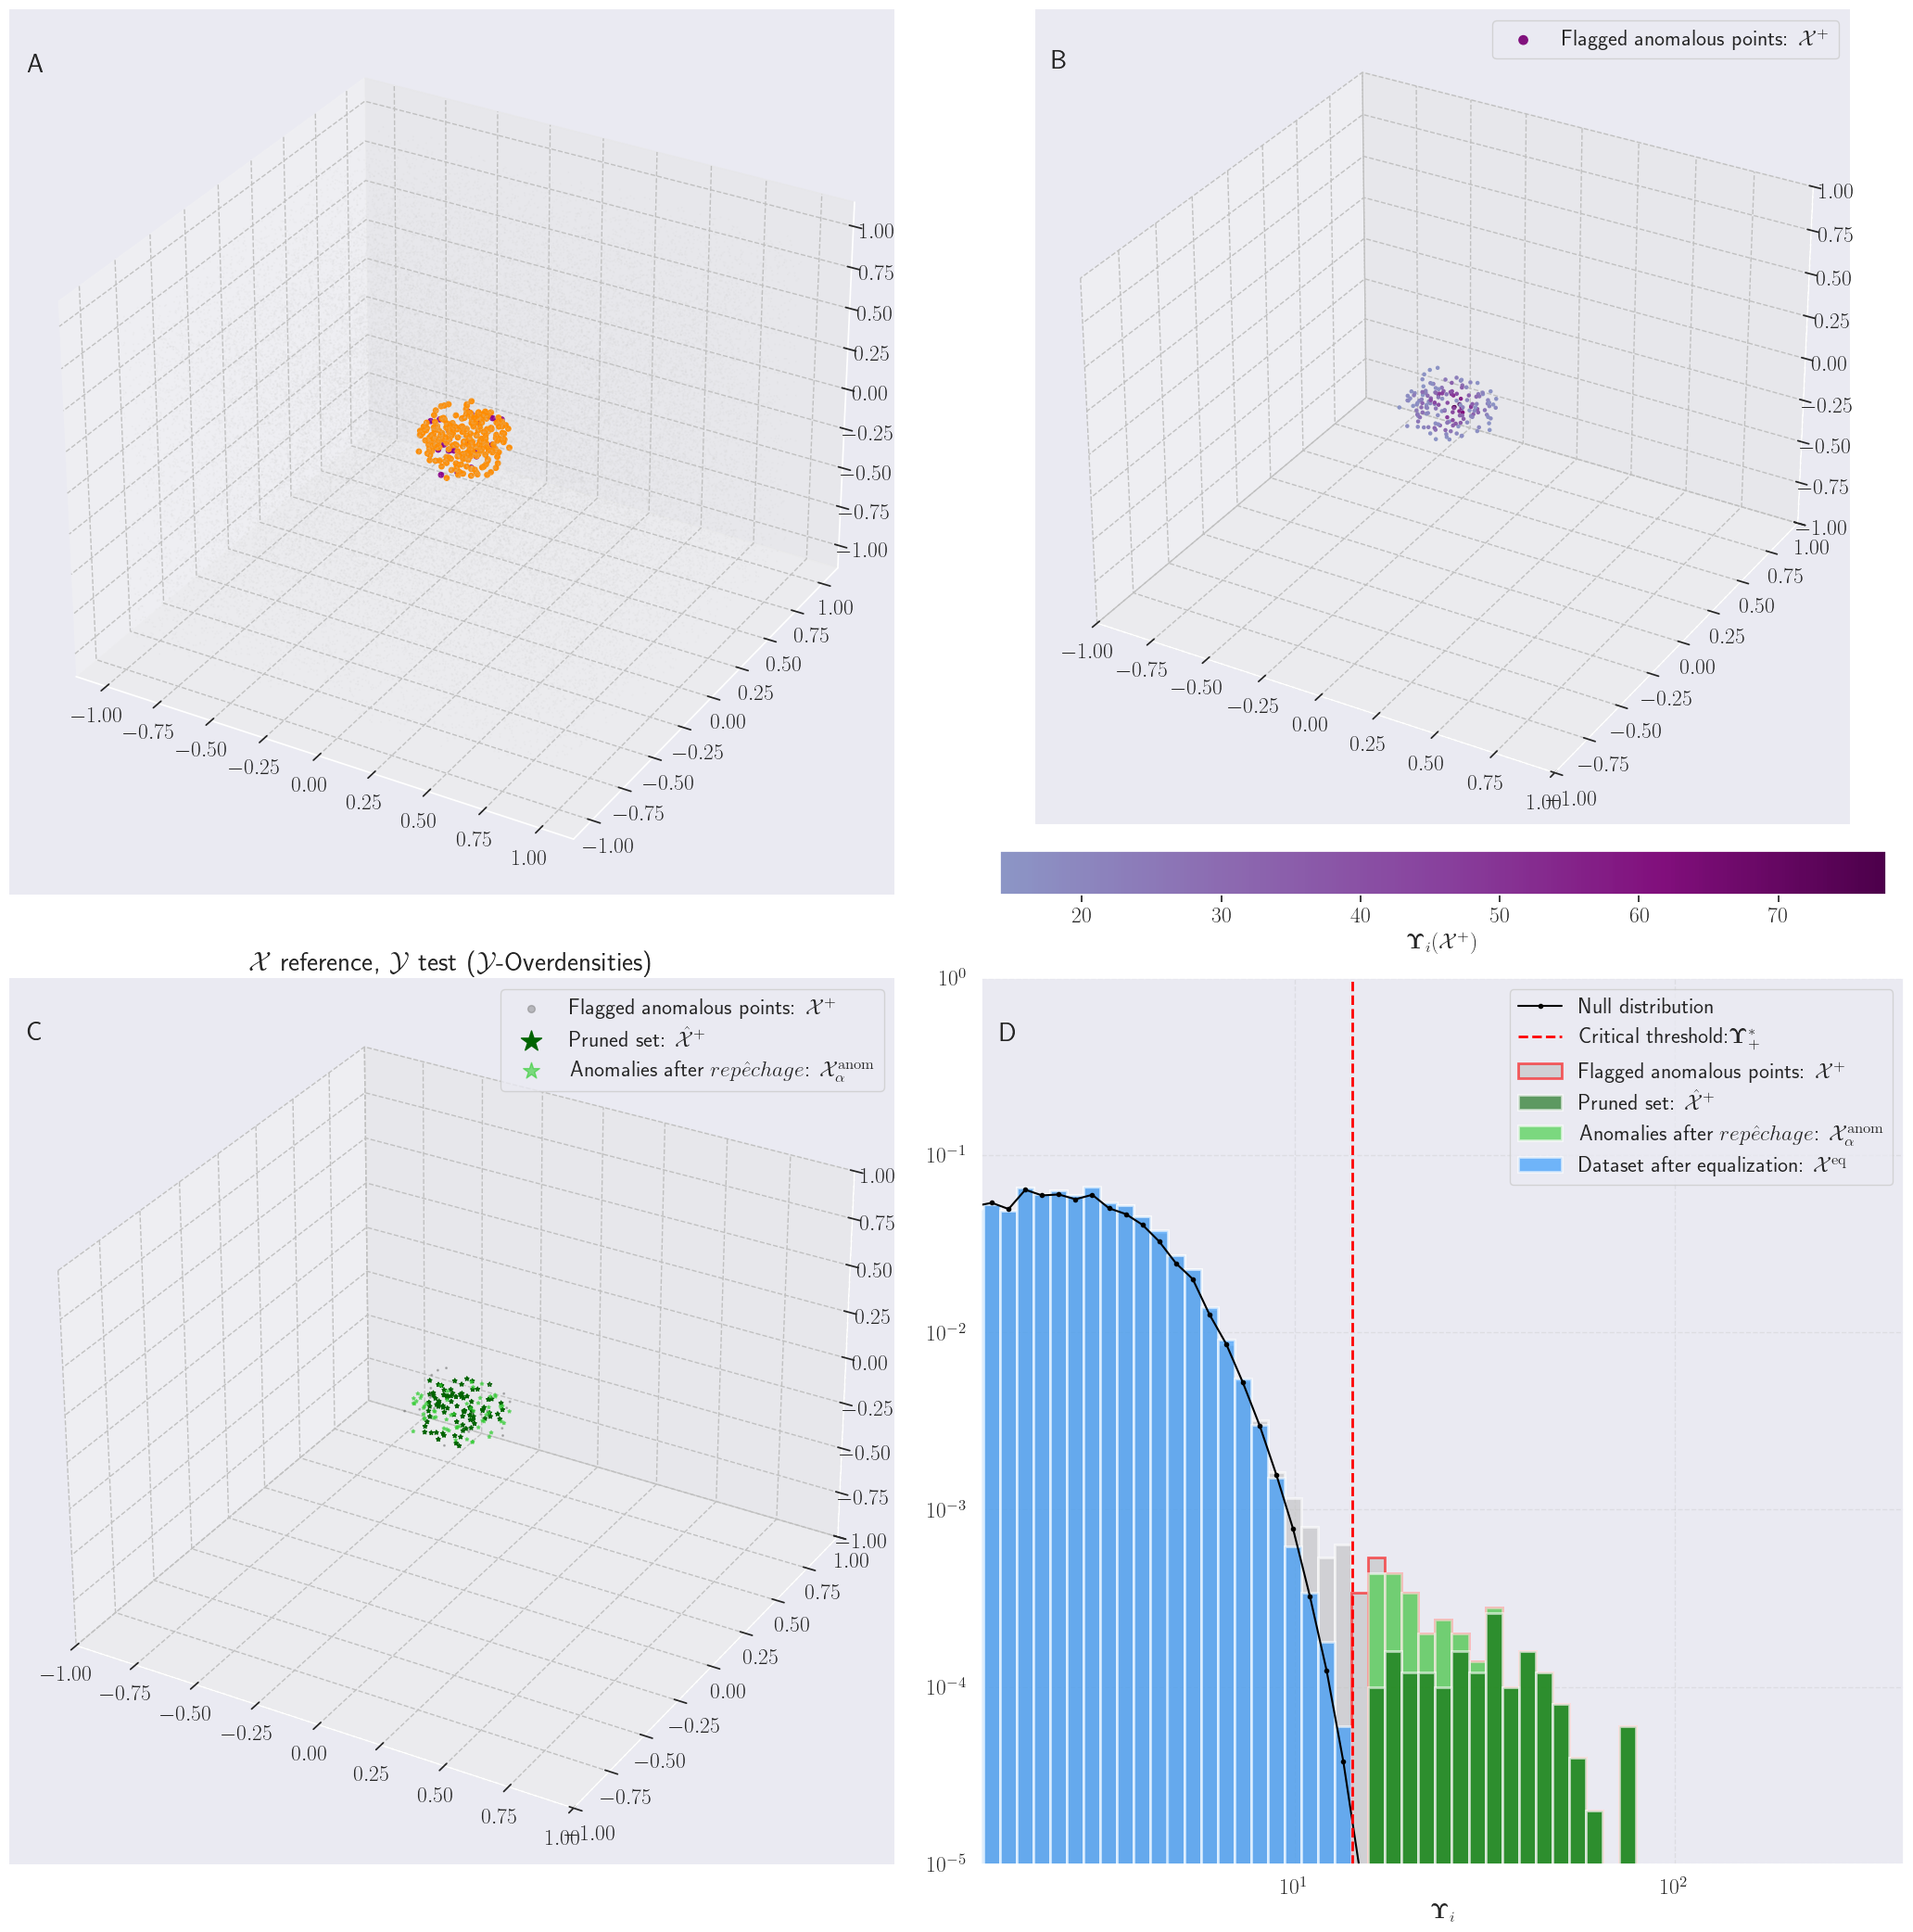

In [15]:
plot_37_article_vanishing(
    EE_book,
    result_dict,
    X,
    Y,
    p,
    points_reference_ball,
    points_test_ball,
    Upsilon_i_equalized_Y,
    Upsilon_i_equalized_X,
    'prova.pdf'
)